# Autopick

Notebook for automated spot detection in '_render.hdf5' file. Output will be a 'render_picks.yaml' that can be opened by the picasso.render module.

![](../../docs/figures/autopick.png)

### Define paths
Define paths to data, i.e. '_render.hdf5' file. 

In [2]:
render_dir='/fs/pool/pool-schwille-paint/Data/p10.ClickReceptor/19-08-06_id141_S1-TCO-TETRA-Pm2/141attachedS1-TCO-TETRA_Pm2-20nM_p35uW_1/19-08-06_FS'
render_name='141attachedS1-TCO-TETRA_Pm2-20nM_p35uW_1_MMStack_Pos0.ome_locs_render.hdf5'

### Load data and import

In [3]:
#################################################### Load packages
import os
import matplotlib.pyplot as plt
import picasso.io
import picasso.render
import lbfcs.autopick as autopick

#### Load data
render_path=os.path.join(render_dir,render_name)
locs_render,info_render=picasso.io.load_locs(render_path)

/fs/home/jstein/.conda/envs/lbFCS/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


ModuleNotFoundError: No module named 'PyQt4'

### Render complete localization list to image
Render complete localization list to image with oversampling of 5 using picasso.render in order to employ picasso's spot detection later

In [18]:
oversampling=5
min_blur_width=0.02

n_locs,image_render=picasso.render.render(
        locs_render,
        info_render,
        oversampling=oversampling,
        viewport=None,
        blur_method="gaussian",
        min_blur_width=min_blur_width
        )

### Spot detection
Employ picasso's spot detection on rendered localization list.
1. Box of lenght = `render_box` is set around each spot detected by its minimum net-gradient (`render_mng`).
2. Each spot will be fitted by 2D Gaussian to determine its center
3. Center coordinates are stored in picklocs_render (be aware that coordinates are now oversampled!)

In [5]:
render_box = 9 
render_mng = 300

picklocs_render=autopick._autopick(image_render,render_mng,render_box,fit=True)

100%|██████████| 6600/6600 [00:13<00:00, 495.24task/s] 


### View detected spots and rendered image
* `view_x` and `view_y` determine bottom left corner of displayed area in real pixels
* `view_width` determines size in real pixels
* `contrast_min` and `contrast_max` set the contrast for the rendered image

If not happy with the results go back to the spot detection and change the minimum net-gradient (`render_mng`). All bright spots should be detected, since flawed dynamics will be filtered out afterwards. At this point we just want to avoid any bias on cluster density!

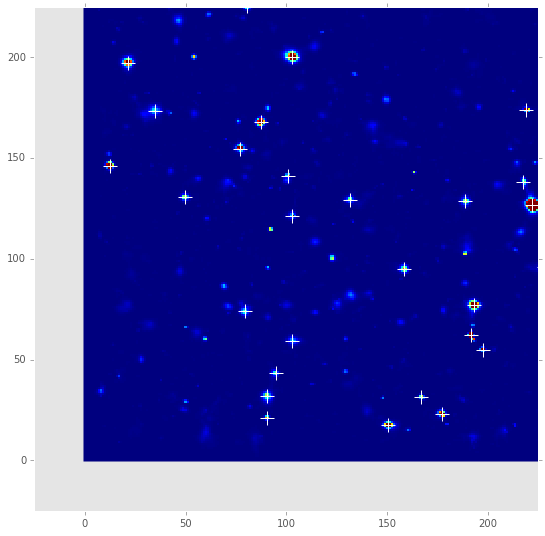

In [22]:
%matplotlib inline

view_x=-5
view_y=-5
view_width=50
contrast_low=0
contrast_max=50

f=plt.figure(num=12,figsize=[7,7])
f.subplots_adjust(bottom=0.,top=1.,left=0.,right=1.)
f.clear()
ax=f.add_subplot(111)
ax.imshow(image_render,cmap='jet',vmin=contrast_low,vmax=contrast_max,interpolation='nearest')
ax.scatter(picklocs_render.x,picklocs_render.y,s=200,marker='+',alpha=1,color='w',linewidths=1)
ax.set_xlim(view_x*oversampling,(view_x+view_width)*oversampling)
ax.set_ylim(view_y*oversampling,(view_y+view_width)*oversampling)
ax.grid(False)

### Save spot centers
Spot centers are saved with extension '_autopick.yaml' and can be imported into picasso.render with a defaulting `pick_diameter` of 2 px.

In [23]:
pick_diameter=2 

### Define saving name
save_path=render_path.replace('.hdf5','_autopicks.yaml')

### Convert picklocs_render back to real coordinates 
picklocs=picklocs_render.copy()
picklocs.x=(picklocs_render.x)/oversampling
picklocs.y=(picklocs_render.y)/oversampling

#### Convert to correct format for picasso
autopick._locs2picks(picklocs,pick_diameter,save_path)

#### Save '_picks.yaml'
info_autopick={'box_size':render_box,'mng':render_mng,'pick_diameter':pick_diameter}

from picasso.io import save_info as save_info
info_list=[info_render,info_autopick]
save_info(save_path.replace('.yaml','_log.yaml'),
              info_list,
              default_flow_style=False)